In [1]:
# Notebook created solely for the final report based off the prototype and presentation ones.
import polars as pl
from great_tables import GT
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

# FRIENDLY NAMES:
FRIENDLY_NAMES = {
    "C": "C",
    "CXX": "C++",
    "RUST": "RUST",
    "RUST_OOB": "UNSAFE RUST (No Out-of-Bounds)",
    "RUST_RAW": "UNSAFE RUST (Raw Pointers)",
}

In [2]:
# GRAPH A: A Direct Benchmark Between Rust, C, and C++
df_win32 = pl.read_csv("sorting-win32.csv").select(["RUST", "C", "CXX"])
df_osx = pl.read_csv("sorting-win32.csv").select(["RUST", "C", "CXX"])

fig, ax = plt.subplots(figsize=(15, 8))

win_plot = ax.boxplot(df_win32, orientation="horizontal", patch_artist=True,
           label=["RUST", "C", "C++"], positions=[0.2, 1.2, 2.2], widths=[0.3, 0.3, 0.3])
osx_plot = ax.boxplot(df_win32, orientation="horizontal", patch_artist=True,
           label=["RUST", "C", "C++"], positions=[-0.2, 0.8, 1.8], widths=[0.3, 0.3, 0.3])

for box in win_plot["boxes"]:
    box.set_facecolor("xkcd:grapefruit")

for box in osx_plot["boxes"]:
    box.set_facecolor("xkcd:light periwinkle")

ax.axhline(y=0.5, color="white", lw=20)
ax.axhline(y=1.5, color="white", lw=20)

ax.set_yticks([0.2, -0.2, 1.2, 0.8, 2.2, 1.8], minor=True)
ax.set_yticklabels(["WINDOWS", "MAC OSX", "WINDOWS", "MAC OSX", "WINDOWS", "MAC OSX"],
                   minor=True, fontweight="bold", color="r", fontsize=12)
ax.set_yticks(range(3))
ax.set_yticklabels(["C", "CXX", "RUST"], fontsize=10, color="red", fontweight="bold");
ax.set_title("Bubble Sort Benchmark: C, C++, Rust", fontsize=18, fontweight="bold")
ax.set_xlabel("Seconds", fontsize=14);

NoDataError: empty CSV

In [ ]:
# GRAPH 2: Benchmarking Unsafe vs Safe Rust -- Revisiting Bubble Sort
# RUST, RUST_OOB, RUST_RAW
HEADERS = ["RUST", "RUST_OOB", "RUST_RAW"]
df_win32 = pl.read_csv("bubble-win32.csv").select(HEADERS)
df_osx = pl.read_csv("bubble-win32.csv").select(HEADERS)

fig, ax = plt.subplots(figsize=(15, 8))

win_plot = ax.boxplot(df_win32, orientation="horizontal", patch_artist=True,
           label=["RUST", "RUST (No OOB)", "RUST (Raw Pointers)"], positions=[0.2, 1.2, 2.2], widths=[0.3, 0.3, 0.3])
osx_plot = ax.boxplot(df_win32, orientation="horizontal", patch_artist=True,
           label=["RUST", "RUST (No OOB)", "RUST (Raw Pointers)"], positions=[-0.2, 0.8, 1.8], widths=[0.3, 0.3, 0.3])

for header, box in zip(win_plot["boxes"],):
    box.set_facecolor("xkcd:grapefruit")

for header, box in osx_plot["boxes"]:
    box.set_facecolor("xkcd:light periwinkle")

ax.axhline(y=0.5, color="white", lw=20)
ax.axhline(y=1.5, color="white", lw=20)

ax.set_yticks([0.2, -0.2, 1.2, 0.8, 2.2, 1.8], minor=True)
ax.set_yticklabels(["WINDOWS", "OSX", "WINDOWS", "OSX", "WINDOWS", "OSX"],
                   minor=True, fontweight="bold", color="r", fontsize=12)
ax.set_yticks(range(3))
ax.set_yticklabels(["RUST (Safe)", "RUST (No Out-Of-Bounds)", "RUST (Raw Pointers)"], fontsize=10, color="red", fontweight="bold");
ax.set_title("Bubble Sort Benchmark: Rust and Unsafe Rust", fontsize=18, fontweight="bold")
ax.set_xlabel("Time in Seconds", fontsize=14);

In [234]:
# GRAPH 3: SISD vs SIMD (FINAL)
df_sisd = pl.read_parquet("sum_sisd_combined.parquet").filter(pl.col("PLATFORM") == "WINDOWS")
df_simd = pl.read_parquet("sum_simd_combined.parquet").filter(pl.col("PLATFORM") == "WINDOWS")
df_sisd.describe()

statistic,TIME,PLATFORM
str,f64,str
"""count""",1e6,"""1000000"""
"""null_count""",0.0,"""0"""
"""mean""",3.9884e-7,null
"""std""",0.000006,null
"""min""",0.0,"""WINDOWS"""
"""25%""",0.0000003,null
"""50%""",0.0000004,null
"""75%""",0.0000004,null
"""max""",0.0033336,"""WINDOWS"""


Text(0.5, 1.0, 'Rust SISD vs SIMD Instructions Benchmark')

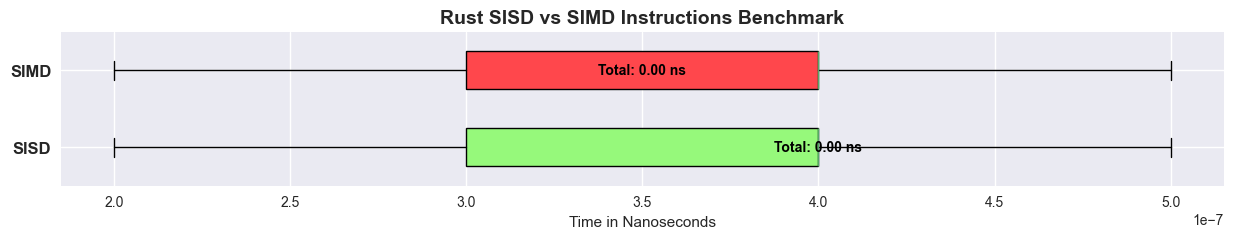

In [225]:
# GRAPH 3: SISD vs SIMD (FINAL)
fig, ax = plt.subplots(figsize=(15, 2))

# SISD:
win_plot_sisd_df = df_sisd["TIME"]
win_plot = ax.boxplot(
    x=win_plot_sisd_df, positions=[1],
    orientation="horizontal", patch_artist=True, showfliers=0, widths=[0.5])
for box in win_plot["boxes"]:
    box.set_facecolor("xkcd:light green")

sisd_total = ax.annotate("Total: %.2f ns" % 0, xy=(win_plot_sisd_df.median() - .5e-7, 1.95), fontweight="bold", color="black")
sisd_total.set_horizontalalignment("center")

# SIMD:
win_plot_simd_df = df_simd["TIME"]
win_plot = ax.boxplot(
    x=win_plot_simd_df, positions=[2],
    orientation="horizontal", patch_artist=True, showfliers=0, widths=[0.5])
for box in win_plot["boxes"]:
    box.set_facecolor("xkcd:light red")
simd_total = ax.annotate("Total: %.2f ns" % 0, xy=(win_plot_simd_df.median(), 0.95), fontweight="bold", color="black")
simd_total.set_horizontalalignment("center")

ax.set_yticks([1, 2])
ax.set_yticklabels(["SISD", "SIMD"], fontweight="bold", fontsize=12)
ax.set_xlabel("Time in Nanoseconds");
ax.set_title("Rust SISD vs SIMD Instructions Benchmark", fontsize=14, fontweight="bold")